# Pokemon Classifier
Made with Fast AI

In [1]:
from fastai.vision.all import *
import nbdev
debug = False

In [2]:
path = Path('.').cwd()/'PokemonData'
path

Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData')

In [3]:
images = get_image_files(path)
images

(#6820) [Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/894adfbb050b4ae28914e18327fee4a4.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/4e3758843ef84f79be49d37d42291ed3.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/c79e64fe6b2647d6a34537536f7487bf.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/564a1c4959974f36b5a25610f7e81f42.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/8be42e059bda4a75bf549a2d08804cdc.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/16c3a65771044f689656e16e0c56f1c0.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/07ea12cb6f2d4236892737

In [4]:
failed = verify_images(images)

In [5]:
failed.map(Path.unlink)

(#0) []

In [6]:
doc(RandomResizedCrop)

In [7]:
pokemon = DataBlock(blocks = (ImageBlock,CategoryBlock),
                    get_items = get_image_files,
                    get_y = parent_label,
                    splitter = RandomSplitter(valid_pct = 0.2, seed = 1),
                    item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'),
                    batch_tfms=aug_transforms(mult=1.5))

In [8]:
dls = pokemon.dataloaders(path)

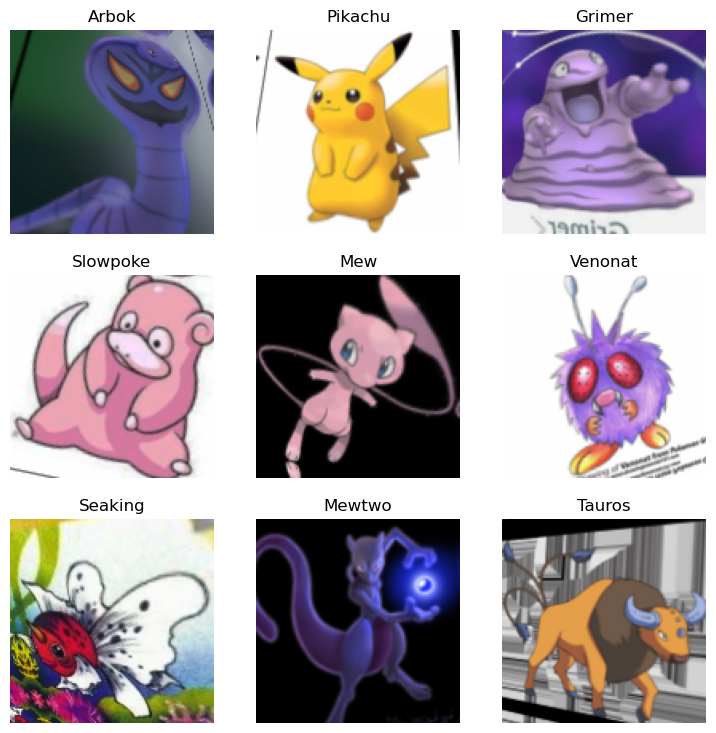

In [9]:
dls.train.show_batch()

## Using Resnet18

In [10]:
learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.965808,2.462596,0.549853,00:15


epoch,train_loss,valid_loss,error_rate,time
0,2.706602,1.722390,0.396628,00:14
1,1.857506,1.052178,0.245601,00:14
2,1.181207,0.723197,0.186950,00:12
3,0.772371,0.583380,0.158358,00:12
4,0.508696,0.522521,0.153959,00:12
5,0.368503,0.497173,0.143695,00:11
6,0.271616,0.458830,0.130499,00:14
7,0.214224,0.436174,0.126100,00:13
8,0.175283,0.437245,0.123167,00:13
9,0.170324,0.434007,0.120968,00:12


After 10 iterations of fine tuning we can see that model has flatten its learning rate in the ending iterations.
## Let's try to find a good learning rate
And see if our performance improves by using it?

0.004365158267319202


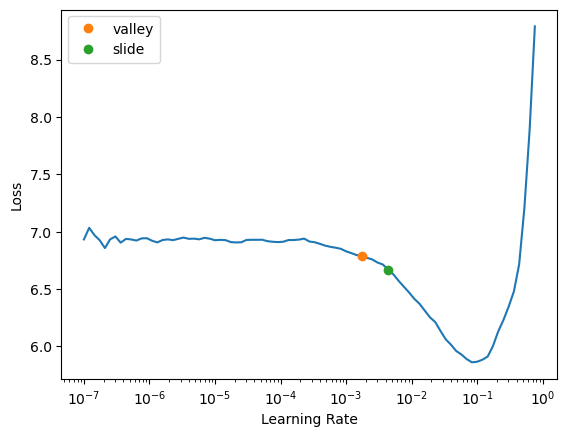

In [21]:
learner2 = vision_learner(dls, resnet18, metrics = error_rate)
l = learner2.lr_find(suggest_funcs=(valley, slide))
print(l.slide)

In [22]:
learner2.fine_tune(5, l.slide)

epoch,train_loss,valid_loss,error_rate,time
0,4.250410,1.898616,0.461877,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.623809,0.941292,0.252933,00:11
1,1.028341,0.682375,0.192082,00:12
2,0.636857,0.542718,0.147361,00:11
3,0.349029,0.454847,0.113636,00:12
4,0.229091,0.428394,0.108504,00:12


In [13]:
doc(plt)

In [14]:
# Using recorder to get values
if debug:
    train_loss = [item[0] for item in learner.recorder.values]
    valid_loss = [item[1] for item in learner.recorder.values]
    error_rate = [1 - item[2] for item in learner.recorder.values]
    print(train_loss, valid_loss, error_rate, sep = '\n')

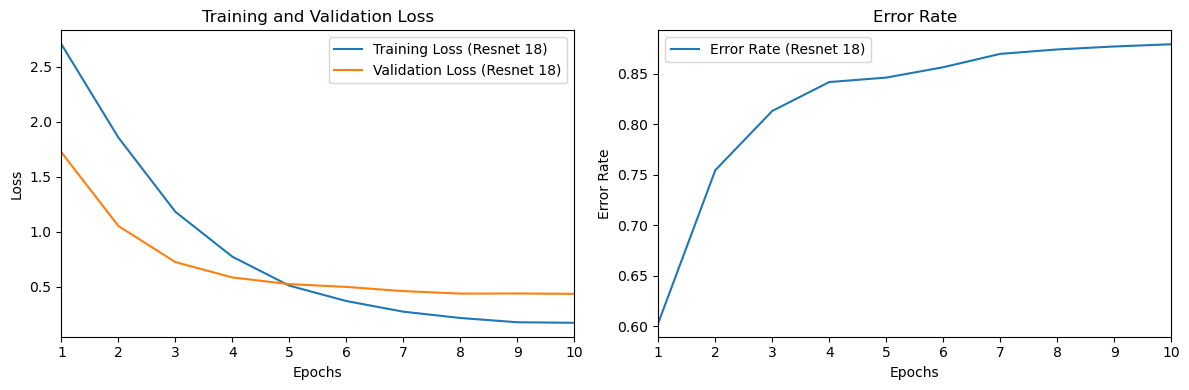

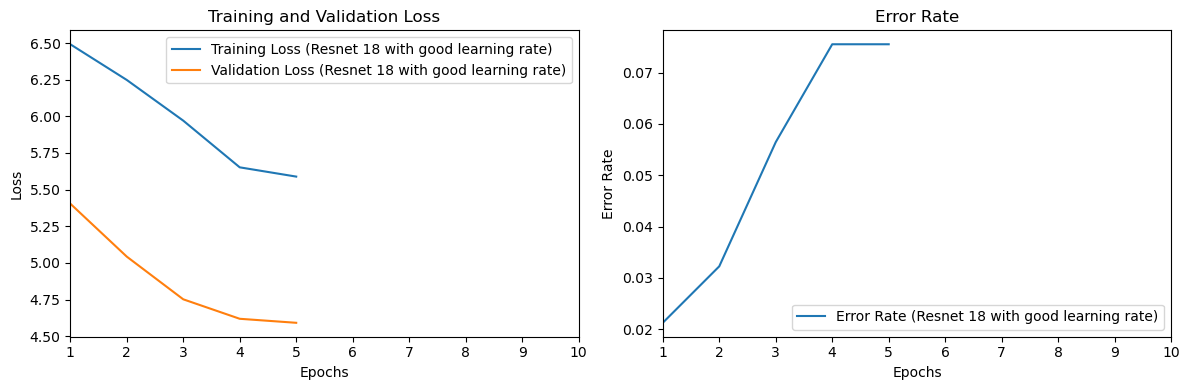

In [15]:
# Plotting training history for both learners
def plot_training_history(learn, label):
    # Extract training loss, validation loss, and error rate from training history
    train_loss = [item[0] for item in learn.recorder.values]
    valid_loss = [item[1] for item in learn.recorder.values]
    error_rate = [1 - item[2] for item in learn.recorder.values]

    # Plotting
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 4))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label=f'Training Loss ({label})')
    plt.plot(epochs, valid_loss, label=f'Validation Loss ({label})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlim(1, 10)
    plt.legend()

    # Plotting error rate
    plt.subplot(1, 2, 2)
    plt.plot(epochs, error_rate[:10], label=f'Error Rate ({label})')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.title('Error Rate')
    plt.xlim(1, 10)
    plt.legend()

    plt.tight_layout()
    plt.show()

if debug:
    # Plotting training history for learner1
    plot_training_history(learner, 'Resnet 18')
    
    # Plotting training history for learner2
    plot_training_history(learner2, 'Resnet 18 with good learning rate')


We got similar accurate model when we used a good learning rate in nearly half iterations.
## Checking prediction

In [16]:
TestInput = Path('.').cwd()/'TestInputs'
categories = learner.dls.vocab

In [17]:
def predict(img):
    pred, idx, probs = learner2.predict(img)
    idx = dict(zip(categories, map(float, probs)))
    return pred, idx[pred]

In [18]:
img = TestInput/'04.png'
predict(img)

('Rapidash', 0.04578628018498421)

In [19]:
learner2.export(fname = 'resnet18_glr_pokemon.pkl')

## Resnet34
Trying out the resnet 34 model to see the comparision

In [24]:
# Resnet34
learner34_1 = vision_learner(dls, resnet34, metrics = error_rate)
learner34_1.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,5.016372,2.357561,0.532258,00:12


epoch,train_loss,valid_loss,error_rate,time
0,2.500234,1.458496,0.337977,00:14
1,1.614385,0.829477,0.206012,00:14
2,0.948798,0.603201,0.158358,00:14
3,0.570228,0.513255,0.134897,00:14
4,0.384945,0.458124,0.120235,00:14
5,0.266048,0.419388,0.108504,00:14
6,0.188456,0.404413,0.099707,00:14
7,0.128991,0.383431,0.100440,00:14
8,0.103187,0.378058,0.097507,00:15
9,0.089589,0.377691,0.096774,00:15


### Resnet34 with good learning rate

0.004365158267319202

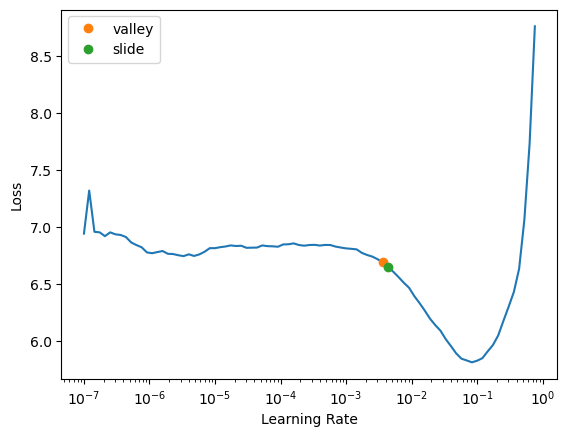

In [29]:
# Resnet34 with good learning rate
learner34_2 = vision_learner(dls, resnet34, metrics = error_rate)
lr = learner34_2.lr_find(suggest_funcs=(valley, slide))
lr.slide

In [30]:
learner34_2.fine_tune(5, lr.slide)

epoch,train_loss,valid_loss,error_rate,time
0,4.203328,1.747029,0.425953,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.477972,0.741926,0.200147,00:15
1,0.907752,0.672446,0.175953,00:15
2,0.541178,0.501797,0.134164,00:15
3,0.282189,0.381754,0.107771,00:17
4,0.171106,0.369103,0.104106,00:16
